In [42]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [43]:
with open("r&m.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [44]:
chars = sorted(list(set(text)))    # vocab build
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi.get(c, 0) for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [45]:
data = torch.tensor(encode(text), dtype=torch.long)  # encode dataset
train_data = data[:int(0.9 * len(data))]
val_data = data[int(0.9 * len(data)):]

In [46]:
batch_size = 32        #hyperparameters for the transformer layer
block_size = 128
n_embd = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-3
max_iters = 5000
eval_interval = 250


In [47]:
def get_batch(split):            # batch loader
    d = train_data if split == 'train' else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

In [48]:
class Transformer(nn.Module):              #transformer
    def __init__(self, vocab_size, n_embd, block_size):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.attn = nn.MultiheadAttention(n_embd, num_heads=2, dropout=0.1, batch_first=True)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ff = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd)
        )
        self.ln2 = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos_emb = self.pos_emb(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.ln1(x)

        mask = torch.tril(torch.ones(T, T, device=idx.device)).bool()
        x, _ = self.attn(x, x, x, attn_mask=~mask)

        x = x + self.ff(self.ln2(x))
        logits = self.head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx


In [49]:
model = Transformer(vocab_size, n_embd, block_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for step in range(max_iters):
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % eval_interval == 0:
        val_loss = 0
        with torch.no_grad():
            for _ in range(10):
                xval, yval = get_batch('val')
                _, vloss = model(xval, yval)
                val_loss += vloss.item()
            val_loss /= 10
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f"Step {step}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")


Step 0, Train Loss: 4.4465, Val Loss: 4.1912
Step 250, Train Loss: 2.4783, Val Loss: 2.5130
Step 500, Train Loss: 2.2367, Val Loss: 2.2908
Step 750, Train Loss: 2.0244, Val Loss: 2.1367
Step 1000, Train Loss: 2.0112, Val Loss: 2.0685
Step 1250, Train Loss: 1.9426, Val Loss: 1.9966
Step 1500, Train Loss: 1.8708, Val Loss: 1.9657
Step 1750, Train Loss: 1.8869, Val Loss: 1.9443
Step 2000, Train Loss: 1.8854, Val Loss: 1.9104
Step 2250, Train Loss: 1.7796, Val Loss: 1.8990
Step 2500, Train Loss: 1.8107, Val Loss: 1.8746
Step 2750, Train Loss: 1.7455, Val Loss: 1.8724
Step 3000, Train Loss: 1.7330, Val Loss: 1.8513
Step 3250, Train Loss: 1.7434, Val Loss: 1.8515
Step 3500, Train Loss: 1.7468, Val Loss: 1.8393
Step 3750, Train Loss: 1.7150, Val Loss: 1.8403
Step 4000, Train Loss: 1.6829, Val Loss: 1.8101
Step 4250, Train Loss: 1.7376, Val Loss: 1.8061
Step 4500, Train Loss: 1.6702, Val Loss: 1.8077
Step 4750, Train Loss: 1.7133, Val Loss: 1.8129


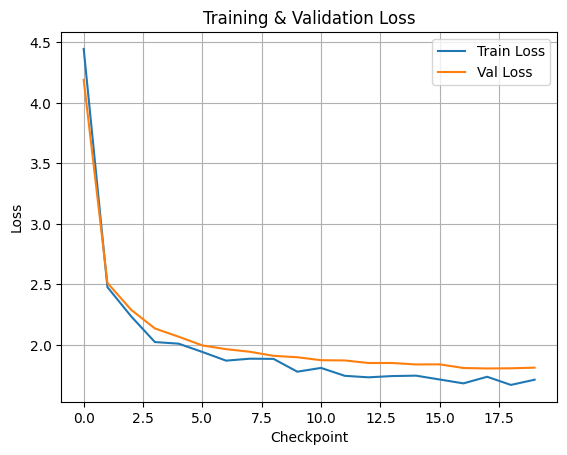

In [50]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Checkpoint')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=500, temperature=0.7, top_k=50)
print(decode(generated[0].tolist()))


I though? Creaahe reall the the him.
Is need way whell, happened in this botted specertive s now time deep in my fail stoom one to for you haved me you got people peopl the part ever.
help.
you got to taing comping for family on me the pices.
The hot of dealle iny gearten themself? Looker.
I'm son from andles, I greanhead funed that spowil pice wish the of long.
The acting I'm gethe mean, had to sere so and to like not somdeone that me.
I call and the there all thugto to stain this what me.
Mort


In [52]:
# %%
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 235987
